# Лабораторная №2: Расчет π на GPU методом Монте-Карло с использованием CUDA.

In [ ]:
!pip install numba
!pip install py-cpuinfo

In [ ]:
from datetime import datetime
from tabulate import tabulate
from datetime import datetime
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
from tabulate import tabulate

import matplotlib.pyplot as plt
import numpy as np
import cpuinfo
import math
import matplotlib.pyplot as plt
import numba
import pandas as pd
import time


Проверка на подлключенное оборудование и его вид

In [ ]:
print('----------------------------------------------------------------------')
print('CPU, выделенный на сервере Colab:', cpuinfo.get_cpu_info()['brand_raw'])
print('GPU, выделенный на сервере Colab:', cuda.get_current_device())
print('----------------------------------------------------------------------')
numba.cuda.detect()

----------------------------------------------------------------------
CPU, выделенный на сервере Colab: Intel(R) Xeon(R) CPU @ 2.20GHz
GPU, выделенный на сервере Colab: <CUDA device 0 'b'Tesla T4''>
----------------------------------------------------------------------
Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-60456da3-9a32-88d6-0a6d-c4b7954d94fc
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

Входные данные

In [ ]:
#размерность блоков фиксированная 16х16
TPB = 16
iter_count = 16

#вектора для хранения и работы с данными
CPU_Pi = []
GPU_Pi = []

CPU_time =[]
GPU_time =[]

len_v = []

acceleration =[]

Функция, вычисляющая значение pi на CPU

In [ ]:
#CPU
def CPU_Pi_monte(iter_count, N):
    res = np.zeros(iter_count) # создаём нулевой массив для хранения результатов
    for i in range(iter_count):
        x = np.random.uniform(size=N) #выборка из параметризованного равномерного распределения (N - выходная форма)
        y = np.random.uniform(size=N) # [0, 1)
        z = x ** 2 + y ** 2 <= 1 #находимся внутри и на границе единичного круга
        res[i] = 4.0 * sum(z) / N # выполняем сокращение с помощью оператора суммы и умножаем результат на 4/N
    return res

 Функция, вычисляющая значение pi на GPU с помощью CUDA.

In [ ]:
#GPU
@cuda.jit#скомпилирует функцию Python, соответствующую спецификации CUDA-Python.
def GPU_Pi_monte(res, rng_st):
  i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x #расчет идентификатора потока
  z = 0
  if i < len(rng_st):
    x = xoroshiro128p_uniform_float32(rng_st, i)# выборка из равномерного распределения, возвращает float32 в диапазоне [0.0, 1.0) и переходит вперед rng_st[i]
    y = xoroshiro128p_uniform_float32(rng_st, i) #  rng_st - массив состояний ГСЧ ,i - смещение в состояниях для обновления
    if x ** 2 + y ** 2 <= 1.0: #находимся внутри и на границе единичного круга
      z += 1
  cuda.atomic.add(res, 0, z) #Возвращает старое значение в позиции индекса, как если бы оно загружалось атомарно, то есть res[0]+=z

In [ ]:
#GPU
def dev_vec(N):

  rng_states = create_xoroshiro128p_states(N, seed=1) #возвращает новый массив, инициализированный для n генераторов случайных чисел; N - количество состояний ГСЧ для создания,
  #seed - начальное значение для списка генераторов
  res = [0] # переменная для записи результата

  dev_res = cuda.to_device(res) #выделение и передача вектора на устройство
  GPU_Pi_monte[N, TPB](dev_res, rng_states) # вызов ядра. GPU_Pi_monte[ griddim ,  BlockDim ]
  #Griddim — количество блоков потоков в сетке
  #blockdim — количество потоков на блок
  tmp_ = dev_res.copy_to_host() #копирование устройство->хост в существующий вектор dev_res (копирование данных в оперативную память)
  pi = 4 * tmp_[0] / N # умножаем результат на 4/N
  return pi

In [ ]:
#функция для запуска расчёта числа pi  и времени выполнения
def main(N):


    cpu_times = time.time() # #засекаем время CPU
    pi_CPU = CPU_Pi_monte(iter_count, N).mean() # вызов функции, вычисляющей pi на CPU
    # pandas.DataFrame.mean() возвращает среднее значение значения CPU_Pi_monte(iter_count, N)
    cpu_time = (time.time() - cpu_times) # вычисляем затраченное время
    CPU_Pi.append(pi_CPU) # добавляем в вектор для хранения pi CPU
    CPU_time.append(cpu_time) # добавляем в вектор для хранения времени CPU

    gpu_times = time.time() #засекаем время GPU
    pi_GPU = dev_vec(N) # вызов функции, вычисляющей pi на GPU

    gpu_time = (time.time() - gpu_times) # вычисляем затраченное время
    GPU_Pi.append(pi_GPU) # добавляем в вектор для хранения pi GPU
    GPU_time.append(gpu_time) # добавляем в вектор для хранения времени GPU



In [ ]:
#запускаем вычисления и добавляем значения N для таблиц и графиков
for N in range(10_000, 100_000 + 1, 10_000):
        main(N)
        len_v.append(N)




In [ ]:
#вычисляем ускорение
for i in range(len(len_v)):
  acceleration.append(CPU_time[i]/GPU_time[i])



## Результаты

In [ ]:
#таблица, показывающая зависимость времени от N и демонстрирующая значение pi на CPU
timing_df = pd.DataFrame({'Device':['CPU',  'CPU' , 'CPU', 'CPU', 'CPU' ,
                                    'CPU',  'CPU' , 'CPU',  'CPU' , 'CPU' ],

                          'N':[f"{len_v[0]}",f"{len_v[1]}", f"{len_v[2]}",
                                         f"{len_v[3]}",f"{len_v[4]}", f"{len_v[5]}",
                               f"{len_v[6]}",f"{len_v[7]}", f"{len_v[8]}",
                               f"{len_v[9]}"],

                          'Time':[CPU_time[0], CPU_time[1],
                                       CPU_time[2], CPU_time[3],
                                       CPU_time[4],  CPU_time[5],
                                       CPU_time[6],  CPU_time[7],
                                       CPU_time[8],  CPU_time[9]],
                          'Pi':[f"{CPU_Pi[0]}", f"{CPU_Pi[1]}",
                                       f"{CPU_Pi[2]}", f"{CPU_Pi[3]}",
                                       f"{CPU_Pi[4]}", f"{CPU_Pi[5]}",
                                       f"{CPU_Pi[6]}", f"{CPU_Pi[7]}",
                                       f"{CPU_Pi[8]}",f"{CPU_Pi[9]}"]




                          })



timing_df

,Device,N,Time,Pi
0,CPU,10000,0.027289,3.1397249999999994
1,CPU,20000,0.037388,3.1451124999999998
2,CPU,30000,0.056290,3.1452083333333336
3,CPU,40000,0.079324,3.14136875
4,CPU,50000,0.094091,3.1390900000000004
5,CPU,60000,0.122997,3.1430208333333334
6,CPU,70000,0.138173,3.1454892857142855
7,CPU,80000,0.152471,3.14123125
8,CPU,90000,0.169382,3.1436833333333336
9,CPU,100000,0.193357,3.1412025


In [ ]:
#таблица, показывающая зависимость времени от N и демонстрирующая значение pi на GPU
timing_df = pd.DataFrame({'Device':['GPU',  'GPU' , 'GPU', 'GPU', 'GPU' ,
                                    'GPU',  'GPU' , 'GPU',  'GPU' , 'GPU' ],

                          'N':[f"{len_v[0]}",f"{len_v[1]}", f"{len_v[2]}",
                                         f"{len_v[3]}",f"{len_v[4]}", f"{len_v[5]}",
                               f"{len_v[6]}",f"{len_v[7]}", f"{len_v[8]}",
                               f"{len_v[9]}"],

                          'Time':[GPU_time[0], GPU_time[1],
                                       GPU_time[2], GPU_time[3],
                                       GPU_time[4],  GPU_time[5],
                                       GPU_time[6],  GPU_time[7],
                                       GPU_time[8],  GPU_time[9]],
                          'Pi':[f"{GPU_Pi[0]}", f"{GPU_Pi[1]}",
                                       f"{GPU_Pi[2]}", f"{GPU_Pi[3]}",
                                       f"{GPU_Pi[4]}", f"{GPU_Pi[5]}",
                                       f"{GPU_Pi[6]}", f"{GPU_Pi[7]}",
                                       f"{GPU_Pi[8]}",f"{GPU_Pi[9]}"]




                          })



timing_df

,Device,N,Time,Pi
0,GPU,10000,0.113958,3.1552
1,GPU,20000,0.006195,3.1578
2,GPU,30000,0.009391,3.1508
3,GPU,40000,0.012481,3.1471
4,GPU,50000,0.014130,3.14304
5,GPU,60000,0.018003,3.1470666666666665
6,GPU,70000,0.021246,3.147542857142857
7,GPU,80000,0.022148,3.14745
8,GPU,90000,0.025959,3.1453777777777776
9,GPU,100000,0.027925,3.14372


In [ ]:
#таблица, показывающая зависимость ускорения от N
timing_df2 = pd.DataFrame({
'N':[f"{len_v[0]}",f"{len_v[1]}",f"{len_v[2]}",
                                         f"{len_v[3]}", f"{len_v[4]}",f"{len_v[5]}",f"{len_v[6]}",f"{len_v[7]}",f"{len_v[8]}",f"{len_v[9]}"],
'Acceleration':[acceleration[0], acceleration[1], acceleration[2],
                                         acceleration[3], acceleration[4],  acceleration[5],  acceleration[6], acceleration[7], acceleration[8], acceleration[9]]
})

timing_df2

,N,Acceleration
0,10000,0.239468
1,20000,6.034943
2,30000,5.994262
3,40000,6.355754
4,50000,6.659040
5,60000,6.832022
6,70000,6.503366
7,80000,6.884235
8,90000,6.525101
9,100000,6.924023


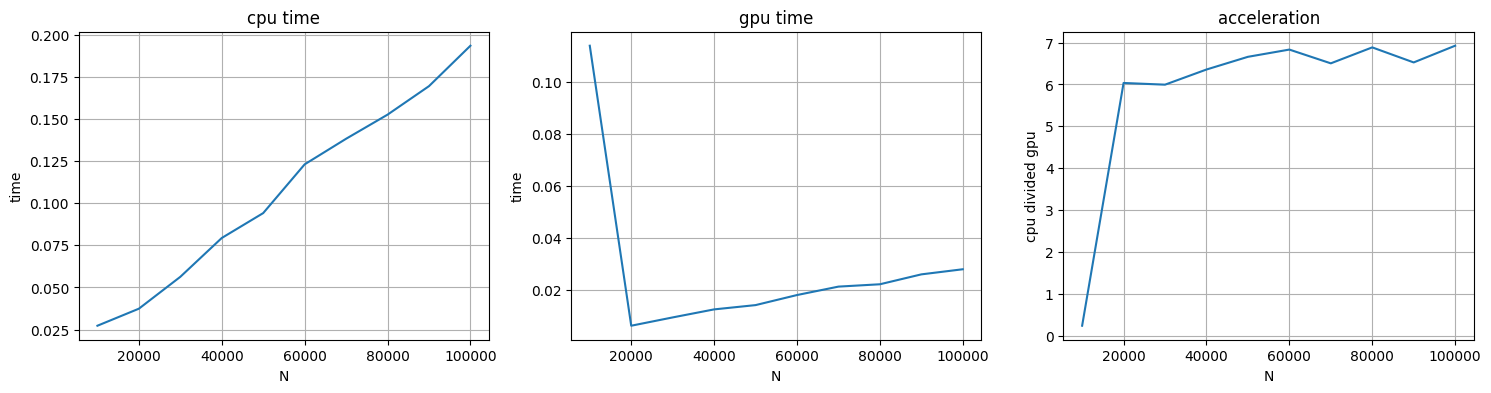

In [ ]:
#визуализация результатов


plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.title("cpu time")
plt.plot(len_v, CPU_time)
plt.xlabel("N")
plt.ylabel("time")
plt.grid()

plt.subplot(1, 3, 2)
plt.title("gpu time")
plt.plot(len_v, GPU_time)
plt.xlabel("N")
plt.ylabel("time")
plt.grid()

plt.subplot(1, 3, 3)
plt.title("acceleration")
plt.plot(len_v, acceleration)
plt.xlabel("N")
plt.ylabel("cpu divided gpu")
plt.grid()

plt.show()